<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/03-modelos/08-ensamble%2BBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de votación (LR+SS3+TFIDF) + BERT

En esta notebook se presetan los experimentos a partir de los datos etiquetados automáticamente a partir de las _features_ extraidas del train dataset con todas las estrategias + la construcción de un clasificador con BERT.

## 0. Configuración de la ejecución

A continuación se genera la configuración de las estrategias que integrarán el sistema de votación para la obtención de instancias:

In [1]:
# Posibilidades : lr, ss3, tfidf
# Combinaciones:
# lr-ss3
# lr-tfidf
# ss3-tfidf
# lr-ss3-tfidf

estrategias_feature_extraction = ['tfidf', 'ss3', 'lr']
ETIQUETADO_MANUAL = False
BOOSTING = False

# Cantidad de instancias para los datasets de las estrategias
CANTIDAD_INSTANCIAS = 200

Se definen algunas características fijas:

In [2]:
# El archivo de test y el train con etiquetado manual es siempre el mismo
TRAIN_FILE_MANUAL = 'correos-train-jaiio-80.csv'
TEST_FILE = 'correos-test-jaiio-20.csv'
atributos_df = ['consulta', 'dia_semana', 'semana_del_mes', 'mes', 'cuatrimestre',
                  'anio', 'hora_discretizada', 'dni_discretizado', 'legajo_discretizado',
                  'posee_legajo', 'posee_telefono', 'carrera_valor', 'proveedor_correo',
                  'cantidad_caracteres', 'proporcion_mayusculas', 'proporcion_letras',
                  'cantidad_tildes', 'cantidad_palabras', 'cantidad_palabras_cortas',
                  'proporcion_palabras_distintas', 'frecuencia_signos_puntuacion',
                  'cantidad_oraciones', 'utiliza_codigo_asignatura', 'score']

Y se generan los datos en función de la cantidad de estrategias a utilizar:

In [3]:
# Se genera el nombre del archivo de instancias a ejecutar en función de las estrategias

# En caso que se realice el ensamble entre las n estrategias
if len(estrategias_feature_extraction)>=1:
  if BOOSTING:
    TRAIN_FILE_E0 = f'dataset-{estrategias_feature_extraction[0]}-200-boosting-prep.csv'
  else:
    TRAIN_FILE_E0 = f'dataset-{estrategias_feature_extraction[0]}-200-prep.csv'
  texto = f'Los dataset a utilizar son: \n\t{TRAIN_FILE_E0}'
  # Se define el if para que ante reiteradas ejecuciones de la notebook no se vuelva a insertar
  if 'clase_e0' not in atributos_df:
    atributos_df.append('clase_e0')

if len(estrategias_feature_extraction)>=2:
  if BOOSTING:
    TRAIN_FILE_E1 = f'dataset-{estrategias_feature_extraction[1]}-200-boosting-prep.csv'
  else:
    TRAIN_FILE_E1 = f'dataset-{estrategias_feature_extraction[1]}-200-prep.csv'
  texto = texto + f'\n\t{TRAIN_FILE_E1}'
  # Se define el if para que ante reiteradas ejecuciones de la notebook no se vuelva a insertar
  if 'clase_e1' not in atributos_df:
    atributos_df.append('clase_e1')

# En caso que se realice el ensamble entre las 3 estrategias
if len(estrategias_feature_extraction)==3:
  if BOOSTING:
    TRAIN_FILE_E2 = f'dataset-{estrategias_feature_extraction[2]}-200-boosting-prep.csv'
  else:
    TRAIN_FILE_E2 = f'dataset-{estrategias_feature_extraction[2]}-200-prep.csv'

  texto = texto + f'\n\t{TRAIN_FILE_E2}' 
  # Se define el if para que ante reiteradas ejecuciones de la notebook no se vuelva a insertar
  if 'clase_e2' not in atributos_df:
    atributos_df.append('clase_e2')

if len(estrategias_feature_extraction)>=1:
  print(texto)

Los dataset a utilizar son: 
	dataset-tfidf-200-prep.csv
	dataset-ss3-200-prep.csv
	dataset-lr-200-prep.csv


## 1. Instalación y Carga de librerías y funciones útiles

### 1.1 Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab:

In [4]:
!pip install simpletransformers
!pip install requests
!pip install wget

     |████████████████████████████████| 221 kB 5.3 MB/s 
     |████████████████████████████████| 8.0 MB 15.6 MB/s 
     |████████████████████████████████| 2.8 MB 50.2 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 1.2 MB 42.3 MB/s 
     |████████████████████████████████| 124 kB 44.6 MB/s 
     |████████████████████████████████| 264 kB 45.5 MB/s 
     |████████████████████████████████| 3.3 MB 37.5 MB/s 
     |████████████████████████████████| 1.7 MB 40.2 MB/s 
     |████████████████████████████████| 895 kB 37.6 MB/s 
     |████████████████████████████████| 636 kB 35.7 MB/s 
     |████████████████████████████████| 50 kB 4.3 MB/s 
     |████████████████████████████████| 133 kB 50.5 MB/s 
     |████████████████████████████████| 170 kB 52.0 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 243 kB 57.0 MB/s 
     |█████████████████

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=2f8b8a333e5e2c1300c50a41d0b339d63c39c60eddfc955d494f8704363e9546
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


### 1.2 Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [5]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df, generar_train_test_set, separar_x_y_rna

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [6]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos, preprocesar_correos_bert

### 1.3. Carga de datos

Cargo la librería warnings para no mostrar las advertencias, pandas para el manejo de df y os para verificar la existencia de los archivos en la carga de datos. Además, cargo en memoria la URL de base de los datasets y una lista de las etiquetas de las distintas clases:

In [7]:
import warnings
import pandas as pd
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'

# Defino las clases y la cantidad a utilizar
etiquetas = get_clases()
CANTIDAD_CLASES = len(etiquetas)

Se cargan los dataframe en memoria con el preprocesamiento de los datos:
- Instancias LR,
- Instancias SS3,
- Instancias TFIDF.
- Instancias etiquetadas manualmente.

In [8]:
if len(estrategias_feature_extraction)>=1:
  # Chequeo sobre si los archivos están en el working directory
  download_files = not(path.exists(TRAIN_FILE_E0))

  df_e0, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_E0, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

  # Muestro salida por consola
  print('Existen {} clases: {}.'.format(len(df_e0.clase.unique()), df_e0.clase.unique()))

  # Me quedo con las N cantidad de instancias con mayor score por clase
  if CANTIDAD_INSTANCIAS<200:
    df_e0 = df_e0.sort_values(['clase','score'], ascending=False).groupby('clase').head(CANTIDAD_INSTANCIAS).reset_index(drop=True)
    df_e0 = df_e0.sample(frac = 1)

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (3200, 25)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


In [9]:
if len(estrategias_feature_extraction)>=2:
  # Chequeo sobre si los archivos están en el working directory
  download_files = not(path.exists(TRAIN_FILE_E1))

  df_e1, test_df_e1, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_E1, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

  # Muestro salida por consola
  print('Existen {} clases: {}.'.format(len(df_e1.clase.unique()), df_e1.clase.unique()))

  # Me quedo con las N cantidad de instancias con mayor score por clase
  if CANTIDAD_INSTANCIAS<200:
    df_e1 = df_e1.sort_values(['clase','score'], ascending=False).groupby('clase').head(CANTIDAD_INSTANCIAS).reset_index(drop=True)
    df_e1 = df_e1.sample(frac = 1)

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (3200, 25)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


Solo en el caso que decida hacer el sistema de votación entre las 3 estrategias inicializo la tercera:

In [10]:
if len(estrategias_feature_extraction)>=3:

  # Chequeo sobre si los archivos están en el working directory
  download_files = not(path.exists(TRAIN_FILE_E2))

  df_e2, test_df_e2, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_E2, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

  # Muestro salida por consola
  print('Existen {} clases: {}.'.format(len(df_e2.clase.unique()), df_e2.clase.unique()))

  # Me quedo con las N cantidad de instancias con mayor score por clase
  if CANTIDAD_INSTANCIAS<200:
    df_e2 = df_e2.sort_values(['clase','score'], ascending=False).groupby('clase').head(CANTIDAD_INSTANCIAS).reset_index(drop=True)
    df_e2 = df_e2.sample(frac = 1)

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (3200, 25)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


Verifico si voy a acumular los datos etiquetados manualmente a los de etiquetado no supervisado y en caso afirmativo los cargo en memoria:

In [11]:
if ETIQUETADO_MANUAL:
 
  # Chequeo sobre si los archivos están en el working directory
  download_files = not(path.exists(TRAIN_FILE_MANUAL))

  train_df_manual, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_MANUAL, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

  # Muestro salida por consola
  print('Existen {} clases: {}.'.format(len(train_df_manual.clase.unique()), train_df_manual.clase.unique()))

### 1.4 Sistema de votación entre estrategias de _feature extraction_

En primer lugar, se joinea mediante el texto de la consulta las estrategias encaradas (según sean dos o tres):

In [12]:
import pandas as pd

# Si se utiliza sólo 1 estrategia, se inicializa el df_join con solo esa
if len(estrategias_feature_extraction)==1:
  df_join = df_e0

# Si se utilizan al menos 2 estrategias, se incorpora también la 2da
if len(estrategias_feature_extraction)>=2:
  df_join = pd.merge(df_e0, df_e1, on='consulta', how='left', suffixes=(None, "_x"))

# Si están las 3 estrategias, se incorpora también la 3era
if len(estrategias_feature_extraction)==3:
  df_join = pd.merge(df_join, df_e2, on='consulta', how='left', suffixes=(None, "_y"))

Borro las instancias con faltantes y verifico el resultado la dimensionalidad del df:

In [13]:
if 'df_join' in globals():
  df_join = df_join.dropna()
  
  print(df_join.shape)

  print(df_join.head())

(2339, 73)
                                            consulta  ...               clase_y
0  hola, hice hace un mes y algo el tramite onlin...  ...  Boleto Universitario
1  hola, en la página dice que tengo asignado el ...  ...  Boleto Universitario
2  yo hace casi un mes hice el tramite para la su...  ...  Boleto Universitario
3  hola que tal?, buenos días.  quería consultar ...  ...  Boleto Universitario
6  hola buenos dias, me comunicaba por el tema de...  ...  Boleto Universitario

[5 rows x 73 columns]


Renombro las clases en función de las estrategias y me quedo sólo con las instancias en que la clase coincide:

In [14]:
if len(estrategias_feature_extraction)==3:
  df_join.rename(columns={'clase_x': 'clase_e0', 'clase_y': 'clase_e1', 'clase': 'clase_e2'}, inplace=True)
  df_join['match_clase'] = ((df_join['clase_e0'] == df_join['clase_e1']) & (df_join['clase_e1'] == df_join['clase_e2']))
elif len(estrategias_feature_extraction)==2:
  df_join.rename(columns={'clase': 'clase_e0', 'clase_x': 'clase_e1'}, inplace=True)
  df_join['match_clase'] = df_join['clase_e0'] == df_join['clase_e1']
elif len(estrategias_feature_extraction)==1:
  df_join.rename(columns={'clase': 'clase_e0'}, inplace=True)
  # Esto se hace por compatibilidad con las otras alternativas (2 y 3 estrategias)
  df_join['match_clase'] = df_join['clase_e0'] == df_join['clase_e0']

if 'df_join' in globals():
  # Me quedo sólo con las instancias en que la clase coincide
  train_df_join = df_join.query('match_clase == True').reset_index()

  train_df_join.shape

Me quedo solo con los atributos que me interesan (elimino duplicados):

In [15]:
if 'df_join' in globals():
  train_df_join = train_df_join[atributos_df]

  train_df_join.columns

Me quedo sólo con una columna de clase dado que son las 3 iguales:

In [16]:
if 'df_join' in globals():
  # Tomo una clase al azar, dado que coinciden las 3
  train_df_join.rename(columns={'clase_e0': 'clase'}, inplace=True)

  # Elimino las columnas que no necesito
  if len(estrategias_feature_extraction)>=2:
    train_df_join.drop(['clase_e1'], inplace=True, axis=1)

  if len(estrategias_feature_extraction)==3:
    train_df_join.drop(['clase_e2'], inplace=True, axis=1)

  train_df_join.shape

Me guardo la columna del score de Elasticsearch para no generar incompatibilidades:

In [17]:
if 'df_join' in globals():
  score = train_df_join['score']
  train_df_join.drop('score', inplace=True, axis=1)

In [18]:
if len(estrategias_feature_extraction)>=1:
  if ETIQUETADO_MANUAL:
    train_df = pd.concat([train_df_manual, train_df_join], axis=0).reset_index(drop=True)
  else:
    train_df = train_df_join
else:
  train_df = train_df_manual

Muestro el dataframe resultante:

In [19]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
train_df.head()

,consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
0,"hola, hice hace un mes y algo el tramite onlin...",4,1,5,1,2019,1,8,4,1,1,3,13,237,0.0,0.797468,1,43,25,0.837209,0.021097,2,0,Boleto Universitario
1,"hola, en la página dice que tengo asignado el ...",1,3,10,2,2019,3,7,4,1,0,3,13,207,0.0,0.816425,2,35,17,0.885714,0.019324,1,0,Boleto Universitario
2,yo hace casi un mes hice el tramite para la su...,0,5,7,1,2018,3,8,4,1,1,3,13,299,0.0,0.799331,0,56,33,0.785714,0.016722,3,0,Boleto Universitario
3,"hola que tal?, buenos días. quería consultar ...",4,2,7,1,2018,0,8,4,1,1,43,13,425,0.0,0.800000,3,75,38,0.773333,0.025882,7,0,Boleto Universitario
4,"hola buenos dias, me comunicaba por el tema de...",1,4,4,1,2019,0,6,4,1,1,5,13,265,0.0,0.803774,1,49,30,0.897959,0.015094,1,0,Boleto Universitario


In [20]:
train_df.shape

(981, 24)

## 1.5 Consolidación del dataset

Se renombran las instancias para que sea compatible con _simpletransformers_:

In [21]:
train_df = train_df[['consulta', 'clase']]
train_df.columns = ['text', 'labels']
test_df = test_df[['consulta', 'clase']]
test_df.columns = ['text', 'labels']

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.labels.unique()), train_df.labels.unique()))

Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


Codifico la clase en un atributo numérico por compatibilidad con simpletransformers:

In [22]:
from sklearn import preprocessing

le_clase = preprocessing.LabelEncoder()
train_df['labels'] = le_clase.fit_transform(train_df['labels'])

train_df.head()

,text,labels
0,"hola, hice hace un mes y algo el tramite onlin...",0
1,"hola, en la página dice que tengo asignado el ...",0
2,yo hace casi un mes hice el tramite para la su...,0
3,"hola que tal?, buenos días. quería consultar ...",0
4,"hola buenos dias, me comunicaba por el tema de...",0


Hago lo mismo para las instancias de test:

In [23]:
test_df['labels'] = le_clase.transform(test_df['labels'])

Verificamos la dimensionalidad del dataframe:

In [24]:
train_df.shape

(981, 2)

# 2. BETO (BERT pre-entrenado por la Universidad de Chile)

Se carga el modelo pre-entrenado de BERT con una definición de hiperparámetros:

In [25]:
from simpletransformers.classification import ClassificationModel

# Cantidad de epochs
epocas = 4

# Hiperparámetros
train_args = {
        'overwrite_output_dir': True,
        'num_train_epochs': epocas,
        'fp16': True,
        'learning_rate': 4e-5,
        'do_lower_case': True,
        'use_early_stopping': True,
        }

# Creamos el ClassificationModel
model = ClassificationModel(
    model_type='bert', 
#    model_name='bert-base-multilingual-cased',
    model_name='dccuchile/bert-base-spanish-wwm-cased',
    num_labels=CANTIDAD_CLASES,
    use_cuda=False,
    args=train_args
)

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

### 2.1 Construcción del modelo

En primer lugar se trabaja con un único clasificador que clasifica y testea las instancias en las 16 clases posibles.

Se realiza el entrenamiento del modelo:

In [26]:
# Modulo para la hora (a efectos de calcular los tiempos de ejecución)
import time

# Se imprime la hora del servidor
hora_servidor = time.strftime('%H:%M:%S', time.localtime())
print(f'Hora de inicio del entrenamiento: {hora_servidor}.')

model.train_model(train_df)


Hora de inicio del entrenamiento: 21:44:58.


  0%|          | 0/981 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/123 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/123 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/123 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/123 [00:00<?, ?it/s]

(492, 0.49617487471172117)

#### 2.2.1 Definición del espacio de búsqueda

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [27]:
sweep_config = {
    "name": "vanilla-sweep-batch-16",
    "method": "bayes",
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 2, "max": 4},
        "learning_rate": {"min": 0, "max": 4e-4},
    },
    "early_terminate": {"type": "hyperband", "min_iter": 6,},
}

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

## 2.2 Testeo del modelo

Se testea el modelo con el método pre-determinado por simpletransformers y además se calculan las métricas a mano para que sea comparable luego con los otros modelos:

In [28]:
model.eval_model(test_df)

  0%|          | 0/200 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

({'eval_loss': 1.2732597209513188, 'mcc': 0.6572843055409604},
 array([[ 5.63879395, -0.67195702, -1.04655337, ..., -0.31171364,
         -1.36392272, -0.4003962 ],
        [-0.47726262,  0.11090392,  0.18563356, ..., -0.52216721,
          0.28293547, -0.38632214],
        [-0.31443095,  3.24570966,  3.79708552, ..., -1.0589385 ,
          0.15395699,  0.4182781 ],
        ...,
        [-0.65466118, -0.17888056, -1.16870463, ...,  6.24937344,
         -1.04153121, -0.85161602],
        [-0.24720441, -0.68370271, -0.1108743 , ..., -0.15482715,
         -0.84971654,  0.02262615],
        [-0.43981314, -0.62419438, -1.12518203, ..., -0.59995168,
         -0.09209158, -0.12220845]]),
 [])

In [29]:
!mkdir evaluate_dir

In [30]:
model.evaluate(test_df, "evaluate_dir")

  0%|          | 0/200 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

({'eval_loss': 1.2732597209513188, 'mcc': 0.6572843055409604},
 array([[ 5.63879395, -0.67195702, -1.04655337, ..., -0.31171364,
         -1.36392272, -0.4003962 ],
        [-0.47726262,  0.11090392,  0.18563356, ..., -0.52216721,
          0.28293547, -0.38632214],
        [-0.31443095,  3.24570966,  3.79708552, ..., -1.0589385 ,
          0.15395699,  0.4182781 ],
        ...,
        [-0.65466118, -0.17888056, -1.16870463, ...,  6.24937344,
         -1.04153121, -0.85161602],
        [-0.24720441, -0.68370271, -0.1108743 , ..., -0.15482715,
         -0.84971654,  0.02262615],
        [-0.43981314, -0.62419438, -1.12518203, ..., -0.59995168,
         -0.09209158, -0.12220845]]),
 [])

Evaluamos el modelo con las métricas convencionales a partir de la predicción en test:

In [31]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, matthews_corrcoef, f1_score, confusion_matrix, recall_score

# Ejecutamos las predicciones sobre testing
y_pred, raw_outputs = model.predict(list(test_df.text))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Se pasan las etiquetas de las predicciones y las clases de train y test para que los resultados sean más sencillos de analizar:

In [32]:
train_df.labels = le_clase.inverse_transform(train_df.labels)

test_df.labels = le_clase.inverse_transform(test_df.labels)

y_pred = le_clase.inverse_transform(y_pred)

Se calculan las métricas sobre test set para el paper:

In [33]:
acc_test = accuracy_score(test_df.labels, y_pred)
precision_test = precision_score(test_df.labels, y_pred, average='weighted')
mcc_test = matthews_corrcoef(test_df.labels, y_pred)
f1_test = f1_score(test_df.labels, y_pred, average='weighted')
recall_test = recall_score(test_df.labels, y_pred, average='weighted')

# Genero un diccionario con los parámetro y el acc en test
dict_test = {}
dict_test['clasificador'] = 'BETO'
dict_test['accuracy'] = acc_test
dict_test['f1_score'] = f1_test
dict_test['precision'] = precision_test
dict_test['mcc'] = mcc_test
dict_test['recall'] = recall_test

# Paso el diccionario a dataframe y lo guardo en un archivo con fecha/hora
results_test = pd.DataFrame([dict_test])
print(f'Estrategia: {estrategias_feature_extraction} - {ETIQUETADO_MANUAL} - Boosting: {BOOSTING} - {CANTIDAD_INSTANCIAS} instancias/clase.')
print(results_test)

Estrategia: ['tfidf', 'ss3', 'lr'] - False - Boosting: False - 200 instancias/clase.
  clasificador  accuracy  f1_score  precision       mcc  recall
0         BETO      0.69  0.686003   0.714411  0.657284    0.69


In [34]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(test_df.labels, y_pred))

                                     precision    recall  f1-score   support

               Boleto Universitario       1.00      0.88      0.93        48
                  Cambio de Carrera       0.17      0.50      0.25         2
                 Cambio de Comisión       0.25      1.00      0.40         2
         Consulta por Equivalencias       0.33      0.67      0.44         3
                Consulta por Legajo       0.29      0.67      0.40         3
Consulta sobre Título Universitario       0.30      1.00      0.46         3
                           Cursadas       0.00      0.00      0.00        19
                   Datos Personales       0.50      0.50      0.50         2
                           Exámenes       0.36      0.80      0.50         5
           Ingreso a la Universidad       0.77      0.61      0.68        33
             Pedido de Certificados       0.93      0.93      0.93        15
             Problemas con la Clave       0.81      0.91      0.86        2

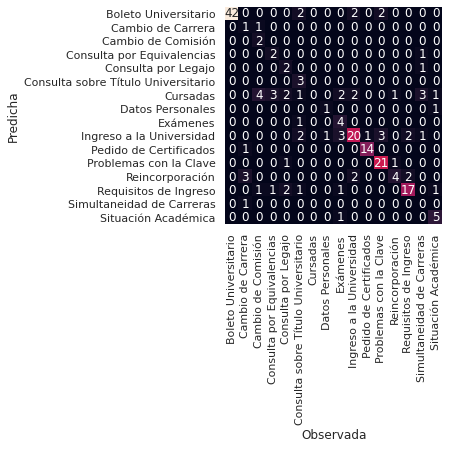

In [35]:
import numpy as np
import seaborn as sns; sns.set()
from sklearn import metrics
import matplotlib.pyplot as plt

mat = metrics.confusion_matrix(test_df.labels, y_pred)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=etiquetas, yticklabels=etiquetas)

plt.xlabel('Observada')
plt.ylabel('Predicha');

### 3. Análisis del error

Se consolida un dataframe para hacer el análisis de la performance:

In [36]:
df_train_error = {'clase': pd.Series(train_df.labels.unique()), 
                  'count_train': train_df.labels.value_counts().reset_index(drop=True)}
  
df_train_error = pd.DataFrame(df_train_error)

# Genero la matriz de confusión
mat = confusion_matrix(test_df.labels, y_pred)
# Calculo el accuracy por clase
avg_class = mat.diagonal()/mat.sum(axis=1)
df_train_error['accuracy'] = pd.Series(avg_class)

# Calculo la cantidad de instancias bien clasificadas
pred_true_class = mat.diagonal()
df_train_error['good_pred'] = pd.Series(pred_true_class)

# Calculo la cantidad de instancias por clase (suma de las rows)
df_train_error['count_test'] = mat.sum(axis=1)

df_train_error

,clase,count_train,accuracy,good_pred,count_test
0,Boleto Universitario,140,0.875000,42,48
1,Cambio de Carrera,125,0.500000,1,2
2,Cambio de Comisión,115,1.000000,2,2
3,Consulta por Equivalencias,114,0.666667,2,3
4,Consulta por Legajo,83,0.666667,2,3
5,Consulta sobre Título Universitario,76,1.000000,3,3
6,Cursadas,71,0.000000,0,19
7,Datos Personales,59,0.500000,1,2
8,Exámenes,44,0.800000,4,5
9,Ingreso a la Universidad,41,0.606061,20,33


Se realiza un plot para analizar la performance por clase:

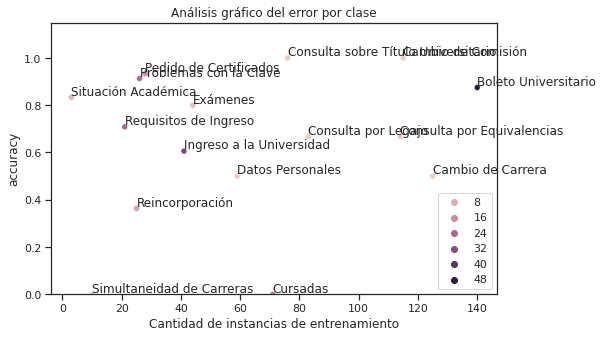

In [37]:
# Cargo las librerías y defino el paño blanco
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

# Ploteo el gráfico general
plt.figure(figsize=(8,5))

sns.scatterplot(data=df_train_error, 
                x="count_train", 
                y="accuracy", 
                hue="count_test")

# Pongo los nombres de las clases
for i in range(df_train_error.shape[0]):
#    if df_train_error.count_test[i]> df_train_error.count_test.mean():
      plt.text(x=df_train_error.count_train[i]+0.01,
              y=df_train_error.accuracy[i]+0.01,
              s=df_train_error.clase[i])

plt.title("Análisis gráfico del error por clase")           #title
# plt.xlim(df_error.score.min()-1,df_error.score.max()+1)   #set x limit
plt.ylim(0.0, 1.15)                                         #set y limit
plt.xlabel("Cantidad de instancias de entrenamiento")       #y label
plt.legend(loc='lower right')

## 4. Persistencia del modelo

Se persiste el modelo en Google Drive:

In [38]:
PERSISTIR = False

if PERSISTIR:
  # Se zipea la salida
  import shutil
  shutil.make_archive('outputs_07_ensamble_beto_210622', 'zip', 'outputs')
  # Se persiste en google colab
  from google.colab import drive
  drive.mount('drive')
  !cp outputs_07_ensamble_beto_210622.zip "drive/My Drive/50jaiio_modelos/"

## Referencias

- Hyperparameter Optimization for Optimum Transformer Models.
 https://towardsdatascience.com/hyperparameter-optimization-for-optimum-transformer-models-b95a32b70949
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05